# COVID-19 Literature Clustering

<h4><center>t-SNE Scatter Plot from CORD-19</center></h4>

In [ ]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/cover/bokeh_plot.png', width=800, height=800)

### Loading Metadata

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

In [ ]:
meta_df.info()

### Fetch All of JSON File Path

In [ ]:
all_json = ! ls $root_path/document_parses/pdf_json
len(all_json)

In [ ]:
all_json[:5]

### Helper Functions

In [ ]:
all_json = [root_path + "document_parses/pdf_json/" + s for s in all_json]
all_json[:5]

In [ ]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

In [ ]:
from tqdm import tqdm
all_json_clean = list()
for idx, entry in tqdm(enumerate(all_json), total=len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    if len(content.body_text) == 0:
        continue
    
    all_json_clean.append(all_json[idx])
    
all_json = all_json_clean
len(all_json)

In [ ]:
import random

random.seed(42)

all_json = random.sample(all_json, 15000)

In [ ]:
all_json[:5]

In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

In [ ]:
from tqdm import tqdm
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in tqdm(enumerate(all_json), total = len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

In [ ]:
df_covid.info()

## Take a Look at the Data:

In [ ]:
df_covid.head()

# Data Pre-processing

In [ ]:
df = df_covid.sample(10000, random_state=42)
del df_covid

In [ ]:
df.dropna(inplace=True)
df.info()

### Handling multiple languages

In [ ]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [ ]:
df = df[df['language'] == 'en'] 
df.info()

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

### Stopwords


In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next let's create a function that will process the text data for us. 

In [ ]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

# Vectorization


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
text = df['processed_text'].values
max_features = 2**12

X = vectorize(text, max_features)

# PCA  & Clustering


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

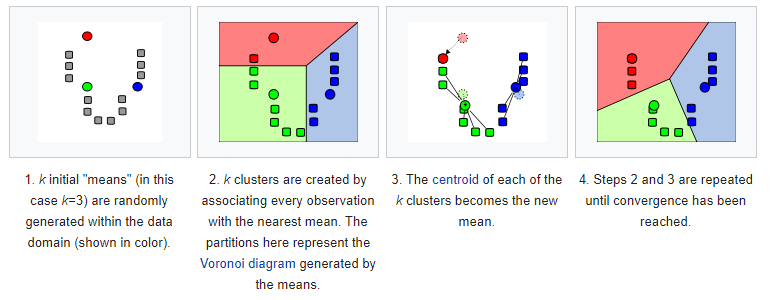

[source](https://en.wikipedia.org/wiki/K-means_clustering)

### How many clusters? 


In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Run k-means

In [ ]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

# Topic Modeling on Each Cluster

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
Image(url='https://miro.medium.com/max/1276/0*Sj65xR38wDwuxhtr.jpg', width=800, height=800)

In [ ]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorizers[0]

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
len(vectorized_data)

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20


lda_models = []

for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [ ]:
all_keywords[0][:10]

In [ ]:
len(all_keywords)

### Save current outputs to file

In [ ]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [ ]:
import pickle

# save the COVID-19 DataFrame
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

# Plotting the data

In [ ]:
! mkdir lib
! ls

In [ ]:
! wget https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/plot_text.py
! wget https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/call_backs.py
! mv plot_text.py lib/.
! mv call_backs.py lib/.
! ls lib/

In [ ]:
# required libraries for plot
from lib.plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from lib.call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

## Load the Keywords per Cluster

In [ ]:
import os

topic_path = os.path.join(os.getcwd(), 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

## Setup

In [ ]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

## Widgets

In [ ]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=25)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider
# column(,,widgetbox(keyword),,widgetbox(slider),, notes, cite, cite2, cite3), plot

## Style

In [ ]:
# STYLE
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "stretch_width"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

## SHOW

In [ ]:
# LAYOUT OF THE PAGE
l = layout([
    [header],
    [description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    [description2, dataset_description, notes, cite],
])
l.sizing_mode = "scale_both"


# show
output_file('t-sne_covid-19_interactive.html')
show(l)